In [1]:
%run include/utils.py
%matplotlib inline

# Nonnegative Matrix Factorization

The goal in nonnegative matrix factorization is to decompose a matrix $X$ into the product of two _smaller_ matrices $T$ and $V$:
\begin{align}
X \simeq TV
\end{align}
Here, $X$, $T$ and $V$ are $I\times J$, $I\times K$ and $K\times J$ dimensional matrices. 

To quantify the quality of approximation, one needs to define a cost function that measures the distance between $X$ and $TV$. A useful measure is the Euclidean distance.

### Euclidean distance
\begin{align}
||X-TV||^2 &= \sum_{i,j} \left( X_{ij}-(TV)_{ij} \right)^2 \\
&= \sum_{ij} \left( X_{ij} - \sum_k T_{ik}V_{kj} \right)^2
\end{align}

To get the update equations, we take the derivative of the cost function wrt $T_{ik}$ and $V_{kj}$:
\begin{align}
\frac{\partial ||X-TV||^2}{\partial T_{ik}} &= \frac{\partial\sum_{ij} \left( X_{ij} - \sum_k T_{ik}V_{kj} \right)^2}{\partial T_{ik}} \\
&= \sum_j -2X_{ij}V_{kj} + 2 V_{kj} \sum_k T_{ik}V_{kj} \\ 
&= \sum_j -2X_{ij}V_{kj} + 2 V_{kj} (TV)_{ij} \\
&= \sum_j -2X_{ij}V^T_{jk} + 2 (TV)_{ij} V^T_{jk} \\
&= C \left[-(XV^T)_{ik} + (TVV^T)_{ik} \right]
\end{align}

So, the update equation for $T_{ik}$ becomes 
\begin{align}
T_{ik} \leftarrow T_{ik} + \eta_{ik} \left[(XV^T)_{ik} - (TVV^T)_{ik} \right]
\end{align}

If we diagonally rescale the variables(?) we get the equivalent multiplicative update rule:
\begin{align}
\eta_{ik} &= \frac{T_{ik}} {(TVV^T)_{ik}} \\
T_{ik} &\leftarrow T_{ik} \frac{(XV^T)_{ik}}{(TVV^T)_{ik}}
\end{align}


### KL-Divergence
If we are to minimize the KL-divergence between X and TV, the update equations should be derived again:

\begin{align}
\text{KL}(X||TV) &= -\sum_{i,j} \left( X_{ij}\log\frac{X_{ij}}{(TV)_{ij}} - X_{ij} + (TV)_{ij}  \right) \\
&= -\sum_{i,j} \left( X_{ij}\log X_{ij} - X_{ij}\log (TV)_{ij} - X_{ij} + (TV)_{ij}  \right) 
\end{align}

We again need partial derivatives wrt $T_{ik}$ and $V_{kj}$. Below, we compute the derivative of negative KL:
\begin{align}
-\frac{\partial \text{KL}(X||TV)}{T_{ik}} &= -\frac{\partial \text{KL}(X||TV)}{\partial (TV)_{ij}}\frac{\partial (TV)_{ij}}{T_{ik}}  \\
&= \left(1-\frac{X_{ij}}{(TV)_{ij}}\right) \left(-\sum_j V_{kj} \right) \\
&= \sum_j V_{kj} \frac{X_{ij}}{(TV)_{ij}} -\sum_j V_{kj}
\end{align}

\begin{align}
-\frac{\partial \text{KL}(X||TV)}{V_{kj}} &= -\frac{\partial \text{KL}(X||TV)}{\partial (TV)_{ij}}\frac{\partial (TV)_{ij}}{V_{kj}} \\
&= \left(1-\frac{X_{ij}}{(TV)_{ij}}\right) \left(-\sum_i T_{ik} \right) \\
&= \sum_i T_{ik} \frac{X_{ij}}{(TV)_{ij}} -\sum_i T_{ik}
\end{align}

\begin{align}
T_{ik} &\leftarrow T_{ik} + \sum_j V_{kj} \frac{X_{ij}}{(TV)_{ij}} -\sum_j V_{kj} \\
V_{kj} &\leftarrow V_{kj} + \sum_i T_{ik} \frac{X_{ij}}{(TV)_{ij}} -\sum_i T_{ik}
\end{align}


## Implementation for Euclidean Distance

In [2]:
import scipy.stats as st

# X ~ TV
def nmf_fit_icm(X, rank, fixed_T=None, at = 10, av = 0.2, MAX_ITER=1000):

    [I, J] = X.shape

    # T
    if fixed_T is None:
        bt = 1.0
        At = at * np.ones((I, rank))
        Bt = bt * np.ones((I, rank))
        Ct = At/Bt
        T = np.random.gamma(at, bt / at, (I, rank))
    else:
        T = np.copy(fixed_T)

    # V
    bv = 1.0
    Av = av * np.ones((rank, J))
    Bv = bv * np.ones((rank, J))
    Cv = Av/Bv
    V = np.random.gamma(av, bv / av, (rank, J))

    M = np.ones(X.shape)
    KL = np.zeros(MAX_ITER)

    T_trans = T.transpose()
    for it in range(MAX_ITER):
        TV = np.dot(T,V)
        if fixed_T is None:
            V_trans = V.transpose()
            T = (At + T * (np.dot((X / TV), V_trans))) / (Ct + np.dot(M, V_trans))
        V = (Av + V * (np.dot(T_trans, (X / TV)))) / (Cv + np.dot(T_trans, M))

        KL[it] = st.entropy(X.flat[:], np.dot(T, V).flat[:])

    # Normalize W:
    s = T.sum(axis=0)
    T = T/s
    
    return [T, V, KL]


# X ~ TV
def nmf_fit_multiplicative(X, rank, MAX_ITER=1000):
    [I, J] = X.shape
    
    # initialization
    T = np.random.dirichlet(np.ones(I),rank).transpose()
    V = np.random.dirichlet(np.ones(rank),J).transpose()
    KL = np.zeros(MAX_ITER)
    
    for it in range(MAX_ITER):
        # update H
        Zw = np.tile(T.sum(axis = 0, keepdims = True).transpose(), J)
        numerator = np.dot(T.transpose(), np.divide(X, np.dot(T, V)))
        V = np.multiply(V, np.divide(numerator, Zw))

        # update W
        Zh = np.tile(V.sum(axis = 1, keepdims = True), I).transpose()
        numerator = np.dot(np.divide(X, np.dot(T, V)), V.transpose())
        T = np.multiply(T, np.divide(numerator, Zh))

        # calculate D(V||WH)
        KL[it] = st.entropy(X.flat[:], np.dot(T, V).flat[:])

    # Normalize W:
    s = T.sum(axis=0)
    T = T/s
    V = V * s.reshape((-1,1))
    
    
    return T, V, KL

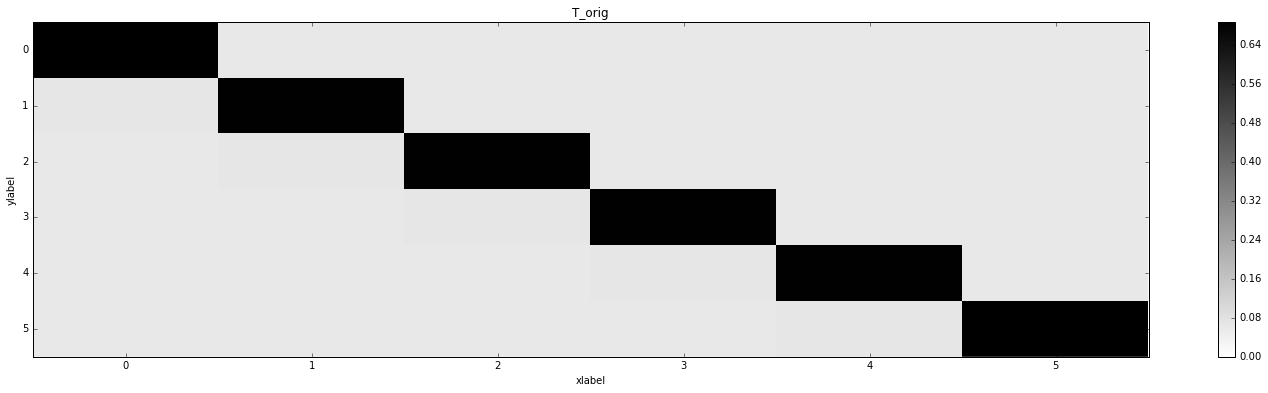

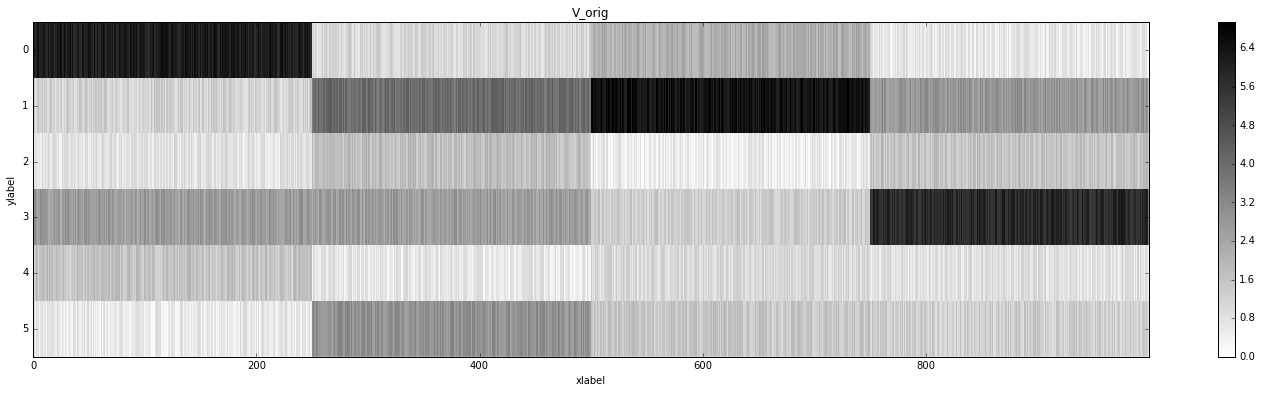

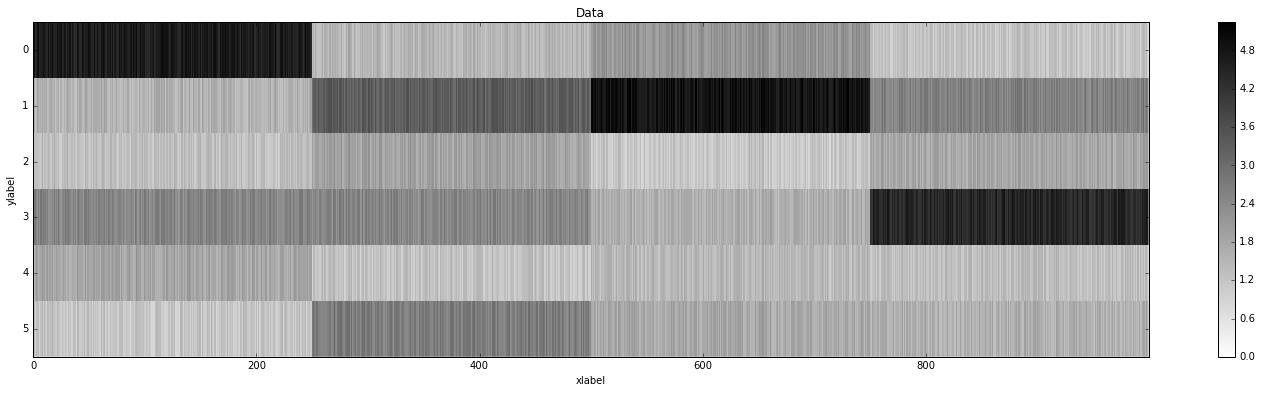

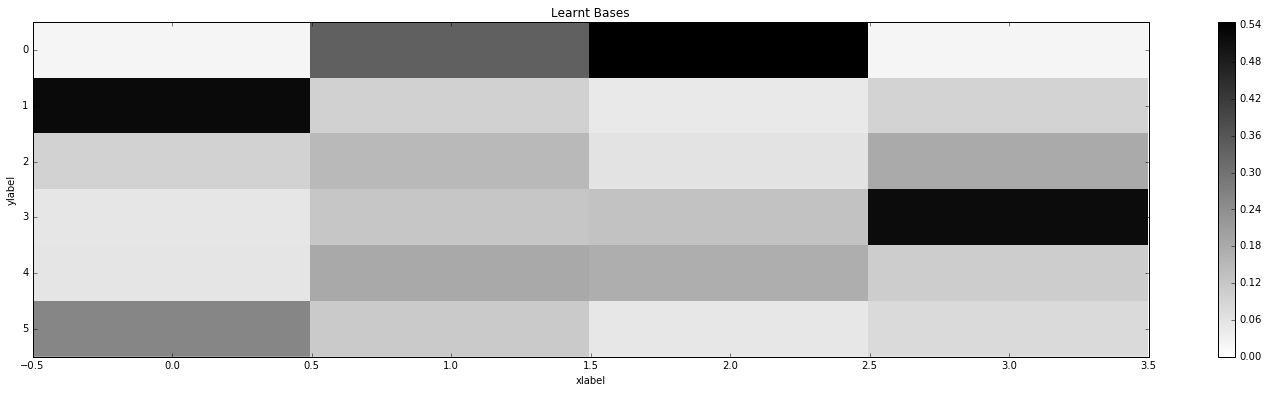

In [3]:
I = 6
J = 1000
R = 4

T_orig = normalize(np.eye(I)+1e-1,axis=0)
V_orig = np.empty((I,0))
for i in range(R):
    tmp = np.random.dirichlet(np.ones(I)).reshape((I,1))*10
    V_sub = np.tile(tmp,(1,int(J/R))) + np.random.random((I,int(J/R)))
    V_orig = np.hstack((V_orig, V_sub))

X = np.dot(T_orig,V_orig)


plot_matrix(T_orig, title='T_orig')
plot_matrix(V_orig, title='V_orig')
plot_matrix(X, title='Data')


Ts, Vs, KLs = nmf_fit_icm(X, rank=R, MAX_ITER=100)
plot_matrix(Ts, title='Learnt Bases')
